# Convolution Neural Networks (CNN)

Nov 27 2023

---

### Why use CNN? 

Several drawbacks with MLP
    
- MLPs use one perceptron for each input. The amount of weights rapidly becomes unmanageable for large images. 
- Not translation invariant. 
- Spatial information is lost with MLP. Nearby pixels are more correlated than distant pixels. 


In [1]:
from pathlib import Path

import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from torch.nn import (
    Conv2d,
    CrossEntropyLoss,
    Dropout,
    Linear,
    Module,
    functional as F,
)
from torch.optim import Adam
from torch.utils.data import DataLoader, SubsetRandomSampler
from torcheval.metrics.functional import (
    multiclass_accuracy,
    multiclass_confusion_matrix,
)
from torchvision import transforms as T
from torchvision.datasets import FashionMNIST
from tqdm.notebook import tqdm



What is Convolution?


![](https://raw.githubusercontent.com/detkov/Convolution-From-Scratch/main/files/conv.gif)

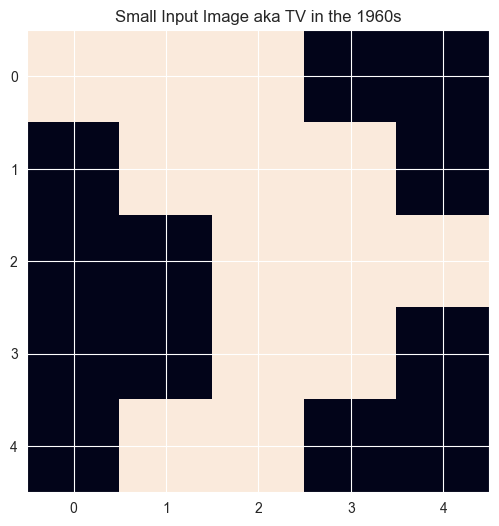

In [2]:
image = np.array(
    [
        [1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0],
        [0, 0, 1, 1, 1],
        [0, 0, 1, 1, 0],
        [0, 1, 1, 0, 0],
    ]
)

fig = plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title("Small Input Image aka TV in the 1960s")
plt.show()

In [3]:
kernel = np.array(
    [
        [1, 0, 1],
        [0, 1, 0],
        [1, 0, 1],
    ]
)

## Implementing Convolution the Bad Way

Python for loops take a while. 

In [4]:
def conv(input: np.ndarray, kernel: np.ndarray):  # ->np.ndarray:
    stride = (1, 1)  # Move one cell over each time.

    k_rows, k_cols = kernel.shape
    i_rows, i_cols = input.shape

    # How big will the Result Matrix be?
    h_out = np.floor((i_rows - k_rows) / stride[0]).astype(int) + 1
    w_out = np.floor((i_cols - k_cols) / stride[1]).astype(int) + 1

    print("output matrix size: ", h_out, w_out)
    dilation = (1, 1)

    matrix_out = np.zeros((h_out, w_out))

    b = k_rows // 2, k_cols // 2
    center_x_0 = b[0] * dilation[0]
    center_y_0 = b[1] * dilation[1]
    for i in range(h_out):
        center_x = center_x_0 + i * stride[0]
        indices_x = [center_x + l * dilation[0] for l in range(-b[0], b[0] + 1)]
        for j in range(w_out):
            center_y = center_y_0 + j * stride[1]
            indices_y = [center_y + l * dilation[1] for l in range(-b[1], b[1] + 1)]

            submatrix = input[indices_x, :][:, indices_y]

            matrix_out[i][j] = np.sum(np.multiply(submatrix, kernel))
    return matrix_out


conv_result = conv(image, kernel)
print(conv_result)

output matrix size:  3 3
[[4. 3. 4.]
 [2. 4. 3.]
 [2. 3. 4.]]


## Let us perform the same operation using pytorch

In [5]:
# conv2d expects a tensor of size (batch_size x channel x width x height)
kernel_tensor = torch.tensor(kernel, dtype=torch.float).unsqueeze(0).unsqueeze(0)
image_tensor = torch.tensor(image, dtype=torch.float).unsqueeze(0).unsqueeze(0)

kernel_tensor.shape, image_tensor.shape

(torch.Size([1, 1, 3, 3]), torch.Size([1, 1, 5, 5]))

In [6]:
# perform the convolution
output_tensor = F.conv2d(image_tensor, kernel_tensor, stride=1, padding=0)
output_tensor

tensor([[[[4., 3., 4.],
          [2., 4., 3.],
          [2., 3., 4.]]]])

## Stride 

![](https://1.bp.blogspot.com/-jGUE3SyV81A/XkrIv9SRW1I/AAAAAAAAAq8/4qrArI50vHAi-EQZ0emslCr09yrK70M0gCEwYBhgL/s1600/appendix_C_eg_2.png)

In [7]:
image = np.array(
    [
        [60, 113, 56, 139, 85, 70],
        [73, 121, 54, 84, 128, 80],
        [131, 99, 70, 129, 127, 90],
        [80, 57, 115, 69, 134, 60],
        [104, 126, 123, 95, 130, 80],
        [45, 26, 13, 95, 130, 99],
    ]
)

kernel = np.array(
    [
        [1, 0],
        [1, 0],
    ]
)

image_tensor = torch.tensor(image, dtype=torch.float).unsqueeze(0).unsqueeze(0)
kernel_tensor = torch.tensor(kernel, dtype=torch.float).unsqueeze(0).unsqueeze(0)

output_tensor = F.conv2d(image_tensor, kernel_tensor, stride=2, padding=0)
output_tensor.shape, output_tensor

(torch.Size([1, 1, 3, 3]),
 tensor([[[[133., 110., 213.],
           [211., 185., 261.],
           [149., 136., 260.]]]]))

## Padding

![](https://miro.medium.com/v2/resize:fit:1358/1*O06nY1U7zoP4vE5AZEnxKA.gif)

In [8]:
image = np.array(
    [
        [60, 113, 56, 139, 85],
        [73, 121, 54, 84, 128],
        [131, 99, 70, 129, 127],
        [80, 57, 115, 69, 134],
        [104, 126, 123, 95, 130],
    ]
)

kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

image_tensor = torch.tensor(image, dtype=torch.float).unsqueeze(0).unsqueeze(0)
kernel_tensor = torch.tensor(kernel, dtype=torch.float).unsqueeze(0).unsqueeze(0)

output_tensor = F.conv2d(image_tensor, kernel_tensor, stride=1, padding=1)
output_tensor.shape, output_tensor

(torch.Size([1, 1, 5, 5]),
 tensor([[[[ 114.,  328.,  -26.,  470.,  158.],
           [  53.,  266.,  -61.,  -30.,  344.],
           [ 403.,  116.,  -47.,  295.,  244.],
           [ 108., -135.,  256., -128.,  344.],
           [ 314.,  346.,  279.,  153.,  421.]]]]))

## Pooling

- Max pooling 
- Average pooling

![](https://i.ibb.co/LSyj00W/nagesh-cnn-intro-8.gif)

In [9]:
image = np.array(
    [
        [7, 3, 5, 2],
        [8, 7, 1, 6],
        [4, 9, 3, 9],
        [0, 8, 4, 5],
    ]
)
image_tensor = torch.tensor(image, dtype=torch.float).unsqueeze(0).unsqueeze(0)
pooled_tensor = F.max_pool2d(image_tensor, kernel_size=2, stride=2)
pooled_tensor.squeeze().numpy()

array([[8., 6.],
       [9., 9.]], dtype=float32)

Hyperparamteres to tune in convolution: 

1. number of filters
2. size of the kernel e.g., (3,3)
3. stride
4. padding

## Towards Convolutional Neural Networks

##### We will build a CNN to classify the images!


FashionMNIST Image Classification

- Download the data again if you did not dowload it 

In [ ]:
# TODO: Change dataset path.
dataset_folder = None

print(f"Dataset Folder: {dataset_folder}")

assert dataset_folder, "Please define your FashionMNIST Download Directory!"

### Set up the training and testing dataset

In [ ]:
transform = T.Compose([T.ToTensor()])

train_set = FashionMNIST(
    root=dataset_folder, download=True, train=True, transform=transform
)
print(f"Train Set Info:\n{train_set}")
test_set = FashionMNIST(
    root=dataset_folder, download=True, train=False, transform=transform
)
print(f"Test Set Info:\n{test_set}")

Text(0.5, 0.98, 'Pixel Power: FashionMNIST $28\\times$28 Images')

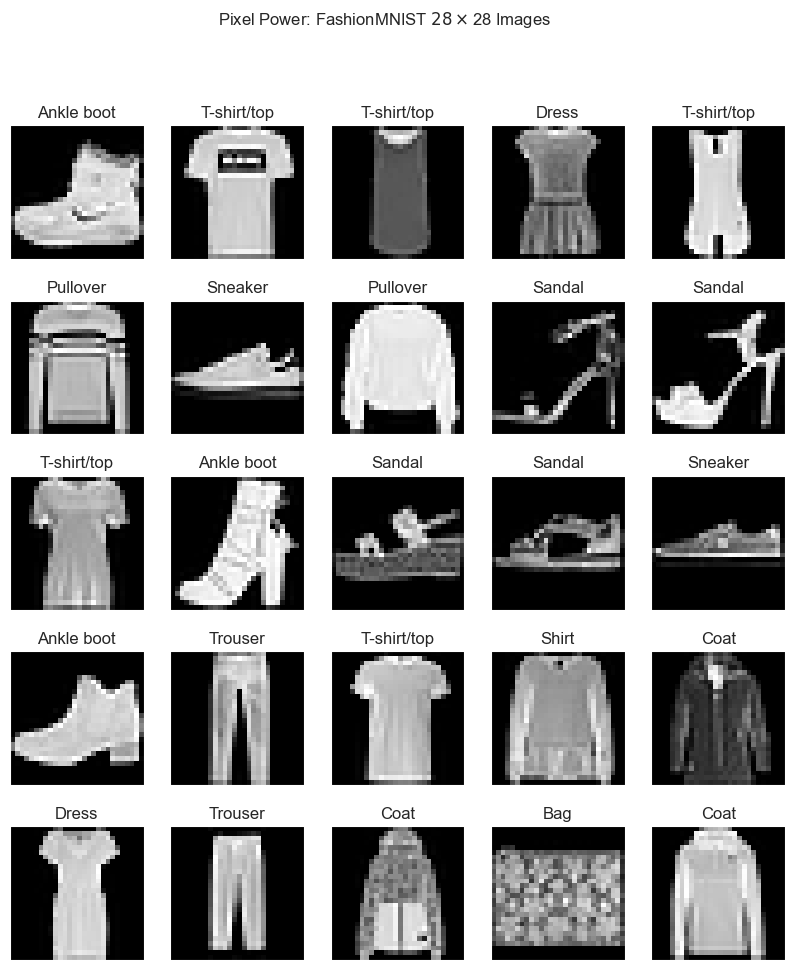

In [12]:
fig = plt.figure(figsize=(10, 11))

img_tensors, img_labels = next(iter(DataLoader(train_set, batch_size=25)))

for i, (img_tensor, img_label) in enumerate(zip(img_tensors, img_labels)):
    img = np.squeeze(img_tensor)
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.set_title(train_set.classes[img_label])
    ax.imshow(img, cmap="gray")
fig.suptitle("Pixel Power: FashionMNIST $28\\times$28 Images")

### Some final data set-up!

We just have a train and test set. We also need a validation set.

Let's split the $60,000$ train images into $48,000$ train images and $12,000$ validation images.

| Split      | Num Images |
|------------|------------|
| Train      | $48,000$   |
| Validation | $12,000$   |
| Test       | $10,000$   | 

In [13]:
images = np.arange(len(train_set))
np.random.shuffle(images)
slice_idx = int(0.20 * len(train_set))

train_sample = SubsetRandomSampler(images[slice_idx:])
val_sample = SubsetRandomSampler(images[:slice_idx])

Load out data into a DataLoader! 

In [14]:
train_loader = DataLoader(train_set, sampler=train_sample, batch_size=32)
val_loader = DataLoader(train_set, sampler=val_sample, batch_size=32)

# No sampler here, since we're just using the whole test set here.
test_loader = DataLoader(test_set, batch_size=32)

In [15]:
print(
    f"Train Loader:\t{len(train_loader)}\nVal. Loader:\t{len(val_loader)}\nTest Loader:\t{len(test_loader)}"
)

Train Loader:	1500
Val. Loader:	375
Test Loader:	313


## Build the CNN

In [16]:
class ConvolutedFashionNetwork(Module):
    """
    Basic CNN for Fashion-MNIST
    """

    def __init__(self):
        super(ConvolutedFashionNetwork, self).__init__()

        # First Conv2D Layer
        # Input -> 1 channel (Image)
        # Output -> 32 Conv Features
        # Kernel Size = 3 X 3 Square
        self.conv1 = Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)

        # Second Conv2D Layer
        # Input -> 32 Features (from conv1)
        # Outputs -> 64 Conv Features
        # Kernel Size = 3 X 3 Square

        self.conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)

        # Drpoout randomly zeroes out some elements
        # The parameter, is the probability p
        self.dropout1 = Dropout(0.25)
        self.dropout2 = Dropout(0.5)

        # First fully connected layer
        self.fc1 = Linear(9216, 128)
        # Second fully connected layer that outputs our 10 labels
        self.fc2 = Linear(128, 10)

    def forward(self, x):
        # Pass data through conv1
        x = self.conv1(x)
        # Use the rectified-linear activation function over x
        x = F.relu(x)

        # Now through conv2
        x = self.conv2(x)
        x = F.relu(x)

        # Run max pooling over x
        x = F.max_pool2d(x, 2)
        # Pass data through dropout1
        # Helps reduce overfitting
        x = self.dropout1(x)
        # Flatten x with start_dim=1
        x = torch.flatten(x, 1)
        # Pass data through ``fc1``
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        # Apply softmax to x
        x = F.log_softmax(x, dim=1)
        return x

In [17]:
def train_model(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    num_epochs,
    device,
):
    """
    Extremely basic model training wrapper.

    The function will use the criterion to compute the loss, and use the optimizer to update the parameters.

    There are cleaner, more elegant ways to do this using various PyTorch modules and external libraries, this function is verbose and simplified for demonstration.

    Parameters
    ----------
    model : A torch.nn.Module object
    criterion : The loss function - aka loss Module, generally an extension of torch.nn
    optimizer : A torch.optim.Optimizer object
    train_loader : The train-set dataloader - A torch.utils.data.DataLoader
    val_loader : The validation-set dataloader - A torch.utils.data.DataLoader
    num_epochs : Number of epochs for model training.
    device : A torch.device object, specifying the device to compute the model on. Useful to ensure all tensors use the same device.

    Returns
    -------
    model: Input model with updated weights.
    history: Dictionary of per-epoch metrics.

    """
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    torch.cuda.empty_cache()
    print(f"{model.__class__.__name__} Training")

    model.to(device)

    for epoch in range(1, num_epochs + 1):
        train_loss = 0.0
        train_total = 0
        train_correct = 0

        print(f"Epoch: {epoch} Train Loop")
        # Train the model for this epoch

        # Enter the model's training mode. Not required for Linear models, but needed here for layers like dropout, batchnorm, etc.
        model.train()

        for inputs, labels in tqdm(train_loader):
            # Zero the gradients.
            optimizer.zero_grad()

            # Load the data onto our device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Compute the forward pass through the network.
            outputs = model(inputs)

            # Compute the loss, using our criterion
            loss = criterion(outputs, labels)

            # Compute epoch statistics.
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_loss += loss.item()

            # Backward step and gradient calculations (optimize)
            loss.backward()
            optimizer.step()  # update weight

        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        print(f"Training Loss {train_loss} Training Accuracy {train_acc}")

        # Evaluate the model
        print(f"Epoch: {epoch} Validation Loop")

        # Enter the model's eval mode. Not required for Linear models, but needed here for layers like dropout, batchnorm, etc.
        model.eval()

        val_correct = 0
        val_total = 0
        val_loss = 0

        # Turn autograd off! We don't want to track gradient changes here. This also speeds up the computations, and reduces memory usage.
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader):
                # Load the data onto our device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Compute the forward pass through the network.
                outputs = model(inputs)

                # Compute the loss, using our criterion
                loss = criterion(outputs, labels)

                # Compute epoch statistics.
                _, predicted = torch.max(outputs.data, 1)
                val_loss += loss.item()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                # This is the validation loop, so we don't update weights, gradients, etc here.

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total

        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Validation Loss: {val_loss} Validation Accuracy: {val_acc}")

    return model, history

In [18]:
cnn_model = ConvolutedFashionNetwork()
criterion = CrossEntropyLoss()
optim = Adam(cnn_model.parameters())
num_epochs = 3
num_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trained_cnn, cnn_history = train_model(
    model=cnn_model,
    criterion=criterion,
    optimizer=optim,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    device=device,
)

ConvolutedFashionNetwork Training
Epoch: 1 Train Loop


  0%|          | 0/1500 [00:00<?, ?it/s]

Training Loss 0.513682181328535 Training Accuracy 0.8143541666666667
Epoch: 1 Validation Loop


  0%|          | 0/375 [00:00<?, ?it/s]

Validation Loss: 0.30951281398534775 Validation Accuracy: 0.891
Epoch: 2 Train Loop


  0%|          | 0/1500 [00:00<?, ?it/s]

Training Loss 0.3461246706446012 Training Accuracy 0.8742916666666667
Epoch: 2 Validation Loop


  0%|          | 0/375 [00:00<?, ?it/s]

Validation Loss: 0.2653293382326762 Validation Accuracy: 0.8994166666666666
Epoch: 3 Train Loop


  0%|          | 0/1500 [00:00<?, ?it/s]

Training Loss 0.3001282699244718 Training Accuracy 0.8911666666666667
Epoch: 3 Validation Loop


  0%|          | 0/375 [00:00<?, ?it/s]

Validation Loss: 0.23756440472106138 Validation Accuracy: 0.9125


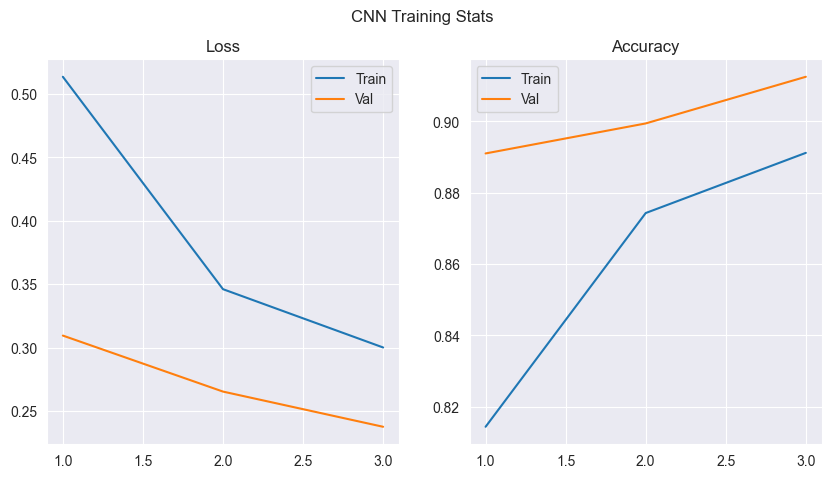

In [19]:
def plot_history(history):
    epochs = list(range(1, len(history["val_loss"]) + 1))
    fig = plt.figure(figsize=(10, 5))

    ax0 = fig.add_subplot(1, 2, 1)
    sns.lineplot(x=epochs, y=history["train_loss"], ax=ax0, label="Train")
    sns.lineplot(x=epochs, y=history["val_loss"], ax=ax0, label="Val")
    ax0.set_title("Loss")
    ax0.legend()

    ax1 = fig.add_subplot(1, 2, 2)
    sns.lineplot(x=epochs, y=history["train_acc"], ax=ax1, label="Train")
    sns.lineplot(x=epochs, y=history["val_acc"], ax=ax1, label="Val")
    ax1.set_title("Accuracy")
    ax1.legend()

    fig.suptitle("CNN Training Stats")
    plt.show()


plot_history(cnn_history)

Test our model

In [20]:
def test_model(model, test_loader, num_classes, device):
    """
    Extremely basic multiclass classification model testing wrapper, calculates Accuracy and generates a confusion matrix.

    There are cleaner, more elegant ways to do this using various PyTorch modules and external libraries, this function is verbose and simplified for demonstration.
    This function will need to be modified for other applications.
    Parameters
    ----------
    model : A torch.nn.Module object
    test_loader : The test-set dataloader - A torch.utils.data.DataLoader
    num_classes : Number of class for multiclass classification. This is often defined in the dataset, or can be retrieved ysing the Datasets's .classes attribute
    device : A torch.device object, specifying the device to compute the model on. Useful to ensure all tensors use the same device.

    Returns
    -------

    None - Prints Accuracy metric and displays confusion matrix.

    """

    torch.cuda.empty_cache()
    print(f"{model.__class__.__name__} Evaluation")

    pred = []
    true = []
    model.to(device)
    model.eval()
    print("Test Loop:")
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            # Load the data onto our device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Compute the forward pass through the network.
            outputs = model(inputs)

            # We don't care about loss, etc here, we're just trying to get predictions.

            _, predicted = torch.max(outputs.data, 1)

            # Add our predictions to the array.
            pred.append(predicted)
            true.append(labels)

    pred_labels = torch.cat(pred)
    true_labels = torch.cat(true)

    accuracy = multiclass_accuracy(
        pred_labels, true_labels, num_classes=num_classes
    ).item()
    cmatrix = multiclass_confusion_matrix(
        pred_labels, true_labels, num_classes=num_classes
    ).tolist()
    sns.heatmap(cmatrix, annot=True)

    print(f"Accuracy: {accuracy}")

ConvolutedFashionNetwork Evaluation
Test Loop:


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy: 0.9052000045776367


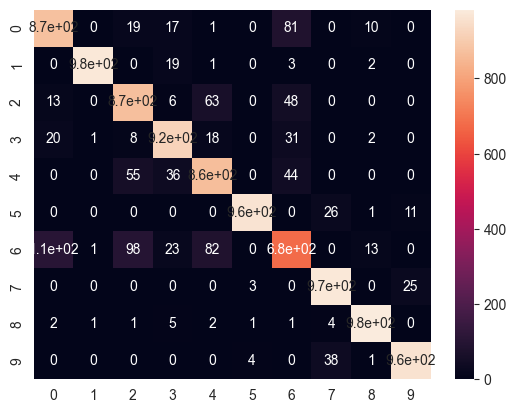

In [21]:
test_model(
    model=cnn_model,
    test_loader=test_loader,
    num_classes=num_classes,
    device=device,
)